# Identifying Patient Cohorts in [MIMIC-II](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3124312/)


In [1]:
%matplotlib inline

In [2]:
import pymysql
import pandas as pd
import getpass
import pandas as pd
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt

In [4]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan········


## Example Query: Heart Rate and Blood Pressure

#### Select a patient from the following ids
* 12613
* 11923
* 517
* 14898

In [9]:
hr = pd.read_sql("""SELECT subject_id, 
                           icustay_id, 
                           charttime, 
                           realtime,
                           value1num,
                           value1uom
                    FROM chartevents
                    WHERE itemid in (211) AND
                          subject_id in (11923)"""
    ,conn)
hr.head()

,subject_id,icustay_id,charttime,realtime,value1num,value1uom
0,11923,14882,2654-09-28 11:45:00,2654-09-28 11:57:00,115.0,BPM
1,11923,14882,2654-09-28 12:00:00,2654-09-28 12:04:00,118.0,BPM
2,11923,14882,2654-09-28 12:05:00,2654-09-28 13:36:00,122.0,BPM
3,11923,14882,2654-09-28 12:10:00,2654-09-28 13:36:00,177.0,BPM
4,11923,14882,2654-09-28 12:15:00,2654-09-28 13:36:00,194.0,BPM


In [32]:
bp = pd.read_sql("""SELECT subject_id, 
                           icustay_id, 
                           charttime, 
                           realtime,
                           value1num,
                           value1uom,
                           value2num,
                           value2uom
                    FROM chartevents
                    WHERE itemid in (6, 51, 455, 6701) AND
                          subject_id in (11923)"""
    ,conn)
bp.head()

,subject_id,icustay_id,charttime,realtime,value1num,value1uom,value2num,value2uom
0,11923,14882,2654-09-28 12:20:00,2654-09-28 13:36:00,117.0,mmHg,46.0,mmHg
1,11923,14882,2654-09-28 12:25:00,2654-09-28 13:36:00,185.0,mmHg,43.0,mmHg
2,11923,14882,2654-09-28 12:30:00,2654-09-28 13:36:00,248.0,mmHg,49.0,mmHg
3,11923,14882,2654-09-28 12:35:00,2654-09-28 13:36:00,192.0,mmHg,50.0,mmHg
4,11923,14882,2654-09-28 12:40:00,2654-09-28 13:36:00,159.0,mmHg,50.0,mmHg


In [33]:
print(bp["icustay_id"].value_counts())
print(bp["subject_id"].value_counts())

14882    4361
14884     199
Name: icustay_id, dtype: int64
11923    4560
Name: subject_id, dtype: int64


In [13]:
hr["icustay_id"].value_counts()

14882    4106
14884     191
Name: icustay_id, dtype: int64

### Plot Heart Rate as a Time Series

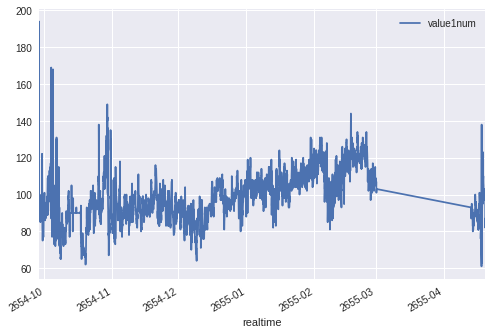

In [14]:
hr.plot(x="realtime", y="value1num")

#### What went wrong?

As part of their de-identication process, the MIMIC2 creators have created large, random time shifts. We can look at the first data point to see what our calendar is

In [16]:
pd.__version__

'0.19.2'

In [ ]:
print(hr["realtime"][0])


#### Our data is from the year 2654 which for whatever reason pandas can't plot.
### We can shift the data back to our own time
#### Compute the timedelta between the now and the first data point.

In [17]:
first_time = hr["realtime"][0]
time_delta = first_time - datetime.datetime.now()
print(time_delta.days)

232741


In [18]:
first_time - time_delta

datetime.datetime(2017, 7, 7, 20, 0, 23, 355507)

## Exercise: Use Pandas apply to create new columns with charttimes and real times shifted to starting at the current  date for the heart rate and blood pressure data

In [34]:
hr["new charttime"]=hr["charttime"]-time_delta
hr["new realtime"]=hr["realtime"]-time_delta

bp["new charttime"]=bp["charttime"]-time_delta
bp["new realtime"]=bp["realtime"]-time_delta

In [35]:
bp.head()

,subject_id,icustay_id,charttime,realtime,value1num,value1uom,value2num,value2uom,new charttime,new realtime
0,11923,14882,2654-09-28 12:20:00,2654-09-28 13:36:00,117.0,mmHg,46.0,mmHg,2017-07-07 20:23:23.355507,2017-07-07 21:39:23.355507
1,11923,14882,2654-09-28 12:25:00,2654-09-28 13:36:00,185.0,mmHg,43.0,mmHg,2017-07-07 20:28:23.355507,2017-07-07 21:39:23.355507
2,11923,14882,2654-09-28 12:30:00,2654-09-28 13:36:00,248.0,mmHg,49.0,mmHg,2017-07-07 20:33:23.355507,2017-07-07 21:39:23.355507
3,11923,14882,2654-09-28 12:35:00,2654-09-28 13:36:00,192.0,mmHg,50.0,mmHg,2017-07-07 20:38:23.355507,2017-07-07 21:39:23.355507
4,11923,14882,2654-09-28 12:40:00,2654-09-28 13:36:00,159.0,mmHg,50.0,mmHg,2017-07-07 20:43:23.355507,2017-07-07 21:39:23.355507


In [36]:
bp.rename(columns={"value1num":"systolic", "value2num":"diastolic"},inplace=True)
bp.head()

,subject_id,icustay_id,charttime,realtime,systolic,value1uom,diastolic,value2uom,new charttime,new realtime
0,11923,14882,2654-09-28 12:20:00,2654-09-28 13:36:00,117.0,mmHg,46.0,mmHg,2017-07-07 20:23:23.355507,2017-07-07 21:39:23.355507
1,11923,14882,2654-09-28 12:25:00,2654-09-28 13:36:00,185.0,mmHg,43.0,mmHg,2017-07-07 20:28:23.355507,2017-07-07 21:39:23.355507
2,11923,14882,2654-09-28 12:30:00,2654-09-28 13:36:00,248.0,mmHg,49.0,mmHg,2017-07-07 20:33:23.355507,2017-07-07 21:39:23.355507
3,11923,14882,2654-09-28 12:35:00,2654-09-28 13:36:00,192.0,mmHg,50.0,mmHg,2017-07-07 20:38:23.355507,2017-07-07 21:39:23.355507
4,11923,14882,2654-09-28 12:40:00,2654-09-28 13:36:00,159.0,mmHg,50.0,mmHg,2017-07-07 20:43:23.355507,2017-07-07 21:39:23.355507


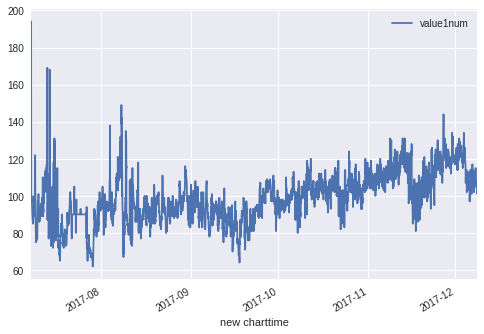

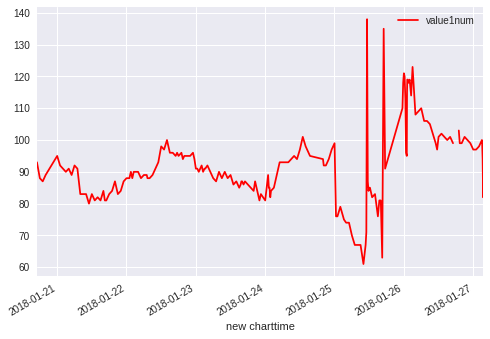

In [23]:
hr[hr["icustay_id"]==14882].plot(x="new charttime", 
                                 y="value1num")
hr[hr["icustay_id"]!=14882].plot(x="new charttime", 
                                 y="value1num", color='red')

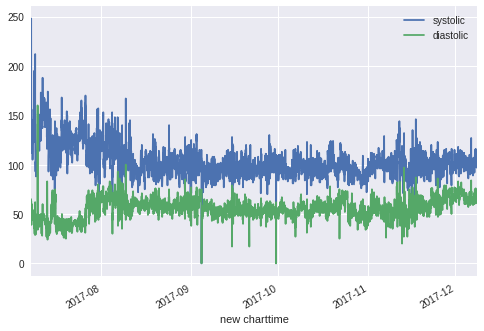

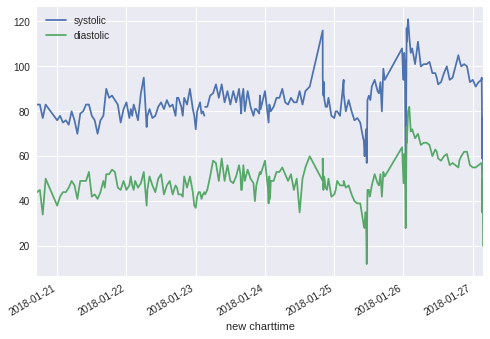

In [37]:
bp[bp["icustay_id"]==14882].plot(x="new charttime", 
                                 y=["systolic", "diastolic"])
bp[bp["icustay_id"]!=14882].plot(x="new charttime", 
                                 y=["systolic", "diastolic"])

In [38]:
hr["chart delta"] = \
hr.apply(lambda x: (x["charttime"] - 
                        x["realtime"]).total_seconds(), axis=1)
hr.head()

,subject_id,icustay_id,charttime,realtime,value1num,value1uom,new charttime,new realtime,chart delta
0,11923,14882,2654-09-28 11:45:00,2654-09-28 11:57:00,115.0,BPM,2017-07-07 19:48:23.355507,2017-07-07 20:00:23.355507,-720.0
1,11923,14882,2654-09-28 12:00:00,2654-09-28 12:04:00,118.0,BPM,2017-07-07 20:03:23.355507,2017-07-07 20:07:23.355507,-240.0
2,11923,14882,2654-09-28 12:05:00,2654-09-28 13:36:00,122.0,BPM,2017-07-07 20:08:23.355507,2017-07-07 21:39:23.355507,-5460.0
3,11923,14882,2654-09-28 12:10:00,2654-09-28 13:36:00,177.0,BPM,2017-07-07 20:13:23.355507,2017-07-07 21:39:23.355507,-5160.0
4,11923,14882,2654-09-28 12:15:00,2654-09-28 13:36:00,194.0,BPM,2017-07-07 20:18:23.355507,2017-07-07 21:39:23.355507,-4860.0


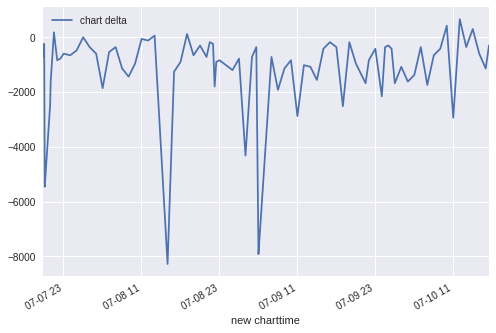

In [39]:
hr[hr["icustay_id"]==14882][:100].plot(x="new charttime",y=["chart delta"])

## Exercise: Timestamp from datetime
#### Using ``time.mktime`` and ``datetime.timetuple`` create timestamps for each measurement

In [ ]:
time.mktime(first_time.timetuple())

In [ ]:
hr[["new charttime","new realtime","chart delta"]][hr["icustay_id"]==14882].plot.line(x="new charttime", 
                               y="chart delta")